# Advection Equation in 1D

We will solve a Advection equation in 1D:

$$
\frac{\partial \phi}{\partial t} + u\frac{\partial \phi}{\partial x} = 0, \qquad \text{where} \quad x  \in [0,1],  \quad t \in [0,1],
$$

with the boundary and initial conditions:

$$
\phi(0, t) = \phi(1, t), \qquad \phi(x, 0) = sin(2 \pi x)
$$

and using $u = 1$.

The reference solution is computed by finite differences *here*.






## Implementation and Training

First, we import the libraries:

In [47]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import datetime
import math
import os

We set the value of u and define the $sine$ function and the value of $\pi$:

In [35]:
u = 1.
sin = torch.sin
pi = math.pi

Now, we set the parameters of the neural network: it has a structure with 2 input ($x, t$) and 1 output ($\phi(x,t)$), 5000 maximum training steps, 2 hidden layers with 32 neurons each, 100 samples and a target minimum loss value of $10^{-4}$.

In [36]:
inputs = 2
outputs = 1
hn_1 = 32
hn_2 = 32
steps = 0
max_steps = 5000
loss = 10
min_loss = 1e-4
log_each = 500
samples = 100
loss_values = []

In this part, we define a new class implementing the activation function $sin(x)$, due to the oscillatory nature of the solution.

In [37]:
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

The multilayer perceptron (MLP) structure is:

In [38]:
mlp = nn.Sequential(
    nn.Linear(inputs,hn_1),
    Sine(),
    nn.Linear(hn_1, hn_2),
    Sine(),
    nn.Linear(hn_2, outputs)
)

optimizer = torch.optim.Adam(mlp.parameters())
criterion = nn.MSELoss()
mlp.train()

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Sine()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Sine()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

In this section, we define a function that calculates the gradients.

In [39]:
def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True, only_inputs=True)
    return grads

Next, we define the main training loop and the timer:

In [40]:
starttime_train = datetime.datetime.now()
print('----Training Started----')

while steps < max_steps and loss > min_loss:
    x = torch.rand(samples)
    t = torch.rand(samples)
    X = torch.stack([x, t], axis=-1)
    X.requires_grad = True
    Y = mlp(X)
    grads = computeGrads(Y, X)
    dphidx = grads[:, :1]
    dphidt = grads[:, 1:]
    ode_loss = criterion(dphidt, -u*dphidx)

    #initial condition
    x = torch.rand(samples)
    t_0 = torch.zeros(samples)
    X_initial = torch.stack([x, t_0], axis=-1)
    Y_initial = mlp(X_initial)
    phi_initial = sin(2*pi*x).unsqueeze(1)
    ic_loss = criterion(Y_initial, phi_initial)

    #boundary conditions
    x_0 = torch.zeros(samples)
    t = torch.rand(samples)
    X_boundary0 = torch.stack([x_0, t], axis=-1)
    Y_boundary0 = mlp(X_boundary0)
    
    x_1 = torch.ones(samples)

    X_boundary1 = torch.stack([x_1, t], axis=-1)
    Y_boundary1 = mlp(X_boundary1)
    
    bc_loss = criterion(Y_boundary0, Y_boundary1)


    optimizer.zero_grad()
    loss = ode_loss + ic_loss  + bc_loss
    loss.backward()
    optimizer.step()

    loss_values.append(loss.detach().numpy())

    if steps % log_each == 0:
        print(f'Step:{steps}| ode_loss {ode_loss.item():.5f} ic_loss {ic_loss.item():.5f} bc_loss {bc_loss.item():.5f}')

    steps+=1

endtime_train = datetime.datetime.now()
train_time = endtime_train - starttime_train
train_time_formatted = train_time.seconds + train_time.microseconds / 1e6
print('---Training Finished---')

print(f'Training Duration: {steps} steps in {train_time_formatted:.3f} seconds')

----Training Started----
Step:0| ode_loss 0.00028 ic_loss 0.53845 bc_loss 0.00073
Step:500| ode_loss 0.00166 ic_loss 0.33830 bc_loss 0.05629
Step:1000| ode_loss 0.00455 ic_loss 0.03513 bc_loss 0.00818
Step:1500| ode_loss 0.00092 ic_loss 0.00201 bc_loss 0.00289
Step:2000| ode_loss 0.00073 ic_loss 0.00078 bc_loss 0.00178
Step:2500| ode_loss 0.00041 ic_loss 0.00036 bc_loss 0.00144
Step:3000| ode_loss 0.00022 ic_loss 0.00029 bc_loss 0.00110
Step:3500| ode_loss 0.00025 ic_loss 0.00018 bc_loss 0.00083
Step:4000| ode_loss 0.00023 ic_loss 0.00015 bc_loss 0.00055
Step:4500| ode_loss 0.00019 ic_loss 0.00004 bc_loss 0.00017
---Training Finished---
Training Duration: 5000 steps in 8.463 seconds


## Visualization

To visualize the model solution, we obtain the output of the trained model and display it as a GIF.

FileNotFoundError: [Errno 2] No such file or directory: '../..GIFs'

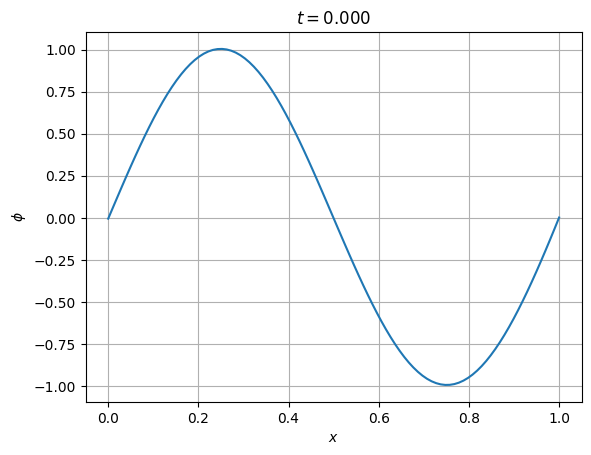

In [ ]:
x = np.linspace(0, 1, samples)
t = np.linspace(0, 1, samples)

phi = [] 
time = []

for t_ in t:
    with torch.no_grad():
        X = torch.stack([torch.from_numpy(x).float(), torch.ones(samples)*t_], axis=-1)
        Y = mlp(X)
    phi.append(Y.detach().numpy())
    time.append(t_)

def update(i):
    ax.clear()
    ax.plot(x, phi[i])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\phi$')
    ax.set_title(f'$t = {time[i]:.3f}$')
    ax.grid(True)
    return ax

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(phi), interval=200)
anim.save('../..GIFs/Forward/advection.gif', dpi=300, writer=PillowWriter(fps=25))
plt.close(fig)

[Animation](https://github.com/munozmfrancisco/PINNs/raw/main/GIFs/Forward/advection.gif)